# Análise de dados

In [1]:
# Configurações
DATA_CSV = 'TR-SLD_v1-3a_shuffled_balanced.csv'
DATA_FRMT = 'wav'
DATASET = 'SLD_v1-3a'
GROUP = 'train'
RANDOM_SAMPLES = 500  # Use None to load all dataset

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import IPython.display as ipd  # To play sound in the notebook
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.tools as tls
import wave
import librosa
import os
import glob
import pandas
import tqdm
import random
from tqdm import tqdm_notebook
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

In [3]:
%matplotlib inline 
color = sns.color_palette()
py.init_notebook_mode(connected=True)
offline.init_notebook_mode()

In [4]:
data = pandas.read_csv(DATA_CSV)
data.columns = ['file_path', 'label']

In [5]:
# Fix the path
data['file_path'] = data['file_path'].apply(lambda fp: fp[23:])

In [6]:
data.head()

file_path   label
0  train/de\de_f_5d2e7\de_f_5d2e7__rmx__lp6000.00...  deutch
1  train/de\de_f_5d2e7\de_f_5d2e7__rmx__lp6000.00...  deutch
2  train/de\de_m_ce41a\de_m_ce41a__rmx__lp6000.00...  deutch
3  train/de\de_m_d2253\de_m_d2253__rmx__lp6000.00...  deutch
4  train/de\de_f_9bd3b\de_f_9bd3b__rmx__lp6000.00...  deutch

In [7]:
def load_wav_file(path):
    sr, b = wavfile.read(path)
    return sr, b

In [8]:
# Load data
if not RANDOM_SAMPLES:
    # Samples == data
    wavs = dict()
    wavs['time_series'] = []
    wavs['sample_rate'] = []
    for path in data['file_path']:
        sr, b = wavfile.read(path)
        wavs['time_series'].append(b)
        wavs['sample_rate'].append(sr)
    samples = pandas.DataFrame(wavs, columns = ['file_path', 'time_series', 'sample_rate'])
    samples['file_path'] = data['file_path']
else:
    # Load #RANDOM_SAMPLES samples
    samples = dict()
    samples['time_series'] = []
    samples['sample_rate'] = []
    df_samples = data.sample(RANDOM_SAMPLES)
    for path in df_samples['file_path']:
        sr, b = wavfile.read(path)
        samples['sample_rate'].append(sr)
        samples['time_series'].append(b)
    df_samples['sample_rate'] = samples['sample_rate']
    df_samples['time_series'] = samples['time_series']
    samples = df_samples
    
samples['label'] = data['label']
samples['nframes'] = samples['time_series'].apply(len)
# The file name is an abreviation
## WARNING: Be careful when changing the number of characters selected, because the analysis of 
## speakers was made based on the name of file
samples['file_name'] = samples['file_path'].apply(lambda p: p.split(os.sep)[-1])
samples.head(40)

file_path       label  \
57733  train/es\es_m_f16e9\es_m_f16e9__rmx__lp6000.00...     spanish   
58760  train/es\es_f_e27d9\es_f_e27d9__rmx__lp6000.00...     spanish   
18072  train/en\en_m_81995\en_m_81995__rmx__lp6000.00...     english   
36442  train/fr\fr_m_9a9f9\fr_m_9a9f9__rmx__lp6000.00...      french   
23469  train/en\en_m_011f3\en_m_011f3__rmx__lp6000.00...     english   
37599  train/fr\fr_m_6ed22\fr_m_6ed22__rmx__lp6000.00...      french   
58917  train/es\es_f_db16e\es_f_db16e__rmx__lp6000.00...     spanish   
16385  train/en\en_f_b6f3c\en_f_b6f3c__rmx__lp6000.00...     english   
12109  train/de\de_f_0809f\de_f_0809f__rmx__lp6000.00...      deutch   
33204  train/fr\fr_f_87079\fr_f_87079__rmx__lp6000.00...      french   
32994  train/fr\fr_m_90ed6\fr_m_90ed6__rmx__lp6000.00...      french   
24460  train/en\en_m_17b5d\en_m_17b5d__rmx__lp6000.00...     english   
5512   train/de\de_f_8e8ed\de_f_8e8ed__rmx__lp6000.00...      deutch   
52566  train/pt\pt_f_37eb7\pt_f_37eb7__rmx__lp6000.00...  portuguese   
57330  train/es\es_m_7e1c8\es_m_7e1c8__rmx__lp6000.00...     spanish   
44020  train/pt\pt_m_b474f\pt_m_b474f__rmx__lp6000.00...  portuguese   
51697  train/pt\pt_f_41bb9\pt_f_41bb9__rmx__lp6000.00...  portuguese   
51072  train/pt\pt_f_52518\pt_f_52518__rmx__lp6000.00...  portuguese   
53813  train/pt\pt_m_45107\pt_m_45107__rmx__lp6000.00...  portuguese   
47385  train/pt\pt_f_52518\pt_f_52518__rmx__lp6000.00...  portuguese   
10824  train/de\de_m_a6f97\de_m_a6f97__rmx__lp6000.00...      deutch   
11718  train/de\de_m_8ea35\de_m_8ea35__rmx__lp6000.00...      deutch   
25765  train/en\en_m_f7d28\en_m_f7d28__rmx__lp6000.00...     english   
1239   train/de\de_f_d9471\de_f_d9471__rmx__lp6000.00...      deutch   
59127  train/es\es_f_56ef0\es_f_56ef0__rmx__lp6000.00...     spanish   
14588  train/en\en_m_17b5d\en_m_17b5d__rmx__lp6000.00...     english   
34136  train/fr\fr_f_c943d\fr_f_c943d__rmx__lp6000.00...      french   
32179  train/fr\fr_m_59472\fr_m_59472__rmx__lp6000.00...      french   
57237  train/es\es_f_ea5fe\es_f_ea5fe__rmx__lp6000.00...     spanish   
4075   train/de\de_m_2cfa3\de_m_2cfa3__rmx__lp6000.00...      deutch   
303    train/de\de_f_6cc5c\de_f_6cc5c__rmx__lp6000.00...      deutch   
67733  train/es\es_m_7e1c8\es_m_7e1c8__rmx__lp6000.00...     spanish   
3648   train/de\de_m_bcc15\de_m_bcc15__rmx__lp6000.00...      deutch   
18822  train/en\en_m_011f3\en_m_011f3__rmx__lp6000.00...     english   
34044  train/fr\fr_f_d2e3d\fr_f_d2e3d__rmx__lp6000.00...      french   
67230  train/es\es_f_bf428\es_f_bf428__rmx__lp6000.00...     spanish   
16631  train/en\en_m_f7d28\en_m_f7d28__rmx__lp6000.00...     english   
53072  train/pt\pt_f_6d7fe\pt_f_6d7fe__rmx__lp6000.00...  portuguese   
12317  train/de\de_f_26ddc\de_f_26ddc__rmx__lp6000.00...      deutch   
26979  train/en\en_f_eddb7\en_f_eddb7__rmx__lp6000.00...     english   

       sample_rate                                        time_series  \
57733        16000  [-27, -31, -28, -23, -8, 12, 17, 28, 31, 16, 6...   
58760        16000  [267, 394, 584, 640, 398, 311, 610, 438, 215, ...   
18072        16000  [-4565, -6510, -7918, -8399, -8784, -9220, -90...   
36442        16000  [0, 1, -1, -2, 0, 0, -1, -1, -1, -3, -1, 0, 1,...   
23469        16000  [-1666, -1475, -1280, -150, -634, -563, 1159, ...   
37599        16000  [6, -35, -36, -34, -11, 10, 0, 12, 50, 23, -62...   
58917        16000  [-4265, -4161, -4210, -4138, -3965, -3919, -35...   
16385        16000  [-257, -431, -164, -520, 5, 271, 12, 814, 561,...   
12109        16000  [-153, -163, -91, -124, -132, -69, -121, -91, ...   
33204        16000  [848, 2076, 2427, 2456, 2955, 2934, 2320, 2683...   
32994        16000  [134, -312, 301, 82, -778, -529, 35, -692, -59...   
24460        16000  [-405, -1910, -3167, -3777, -3887, -3814, -372...   
5512         16000  [7004416, 6204416, 269312, 2795520, 2617728, 3...   
52566        16000  [-5543, -6361, -7096, -7786, -8203, -8270, -82...   

In [9]:
data['file_name'] = data['file_path'].apply(lambda p: p.split(os.sep)[-1][:-4][:24])
full_names = [x.split(os.sep)[-1] for x in data['file_path']]
# Data augmentation
def gftrv(full_n, feature):
    x = full_n.split(feature, 1)
    if len(x) > 1:
        if feature == 'lp':
            return x[1].split('_')[0]
        return x[1].split('_')[1]
    return None
speeds = [gftrv(x, '_sp') for x in full_names]
pitches = [gftrv(x, '_pt') for x in full_names]
noises = [gftrv(x, '_ns') for x in full_names]
low_pass = [gftrv(x, '_lp') for x in full_names]
data['speed_changing'] = speeds
data['pitch_changing'] = pitches
data['noise_add'] = noises
data['low_pass'] = low_pass
data['augmented_data'] = list(map(lambda x: x[0] is not None or x[1] is not None or x[2] is not None or x[3] is not None,
                                 list(zip(speeds, pitches, noises, low_pass))))
export_csv = data.to_csv (r'[DF]{}'.format(DATA_CSV), index = None, header=True) 


In [10]:
data.head()

file_path   label  \
0  train/de\de_f_5d2e7\de_f_5d2e7__rmx__lp6000.00...  deutch   
1  train/de\de_f_5d2e7\de_f_5d2e7__rmx__lp6000.00...  deutch   
2  train/de\de_m_ce41a\de_m_ce41a__rmx__lp6000.00...  deutch   
3  train/de\de_m_d2253\de_m_d2253__rmx__lp6000.00...  deutch   
4  train/de\de_f_9bd3b\de_f_9bd3b__rmx__lp6000.00...  deutch   

                  file_name speed_changing pitch_changing noise_add low_pass  \
0  de_f_5d2e7__rmx__lp6000.           None         -200.0      None            
1  de_f_5d2e7__rmx__lp6000.           1.10           None      None            
2  de_m_ce41a__rmx__lp6000.           0.95           None      None            
3  de_m_d2253__rmx__lp6000.           0.80           None      None            
4  de_f_9bd3b__rmx__lp6000.           0.80           None      None            

   augmented_data  
0            True  
1            True  
2            True  
3            True  
4            True

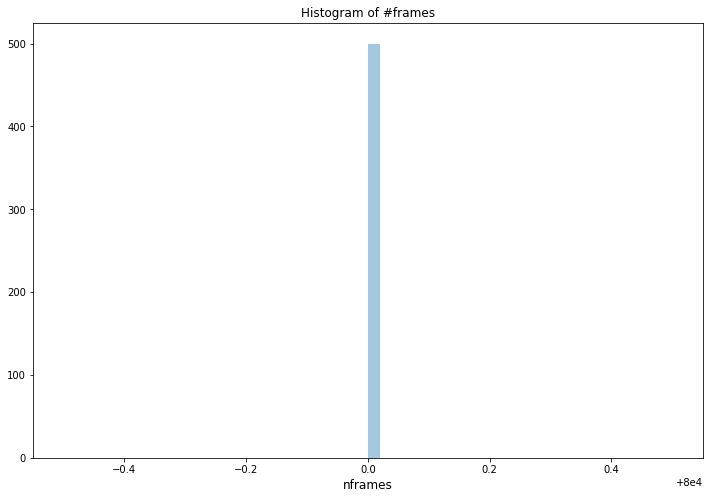

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(samples.nframes.values, bins=50, kde=False)
plt.xlabel('nframes', fontsize=12)
plt.title("Histogram of #frames")
plt.show()

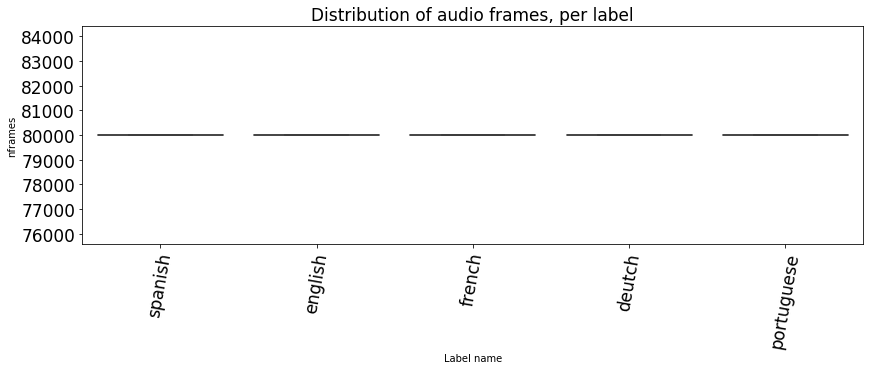

In [12]:
plt.figure(figsize=(14,4))
boxplot = sns.boxplot(x="label", y="nframes", data=samples)
boxplot.set(xlabel='', ylabel='')
plt.title('Distribution of audio frames, per label', fontsize=17)
plt.xticks(rotation=80, fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('Label name')
plt.ylabel('nframes')
plt.show()

In [13]:
temp = data.sort_values(by='label')
temp.head()

file_path   label  \
0     train/de\de_f_5d2e7\de_f_5d2e7__rmx__lp6000.00...  deutch   
9122  train/de\de_m_ab485\de_m_ab485__rmx__lp6000.00...  deutch   
9123  train/de\de_m_fc6bd\de_m_fc6bd__rmx__lp6000.00...  deutch   
9124  train/de\de_f_2825f\de_f_2825f__rmx__lp6000.00...  deutch   
9125  train/de\de_m_8ea35\de_m_8ea35__rmx__lp6000.00...  deutch   

                     file_name speed_changing pitch_changing noise_add  \
0     de_f_5d2e7__rmx__lp6000.           None         -200.0      None   
9122  de_m_ab485__rmx__lp6000.           None           None    street   
9123  de_m_fc6bd__rmx__lp6000.           None         -200.0      None   
9124  de_f_2825f__rmx__lp6000.           None           None    street   
9125  de_m_8ea35__rmx__lp6000.           None         -200.0      None   

     low_pass  augmented_data  
0                        True  
9122                     True  
9123                     True  
9124                     True  
9125                     True

In [14]:
def get_index_label(label):
    for i, ins in enumerate(temp['label']):
        if ins == label:
            return i
get_index_label('english')

13691

Total number of labels in training data :  5
Labels are :  ['deutch' 'english' 'french' 'portuguese' 'spanish']


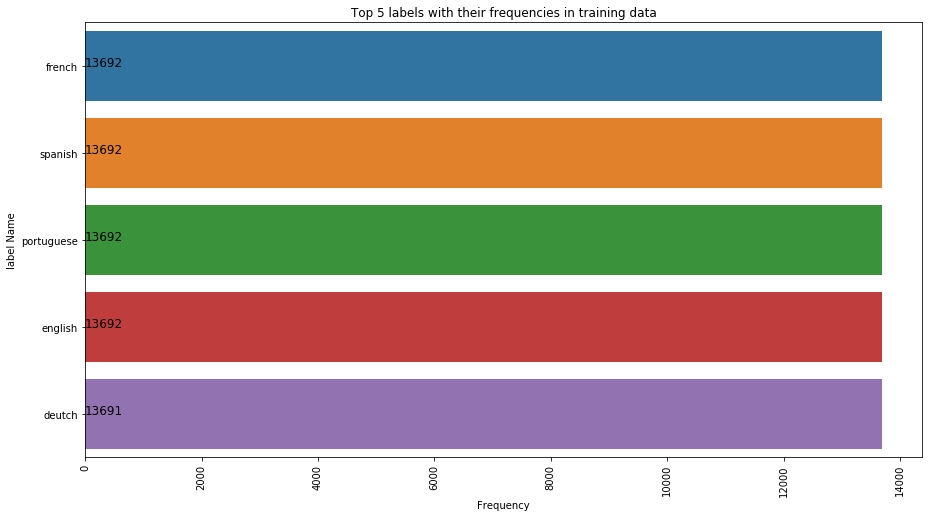

In [15]:
print("Total number of labels in training data : ",len(data['label'].value_counts()))
print("Labels are : ", data['label'].unique())
plt.figure(figsize=(15,8))
audio_type = data['label'].value_counts().head(5)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('label Name')
plt.title("Top 5 labels with their frequencies in training data")
plt.show()

In [16]:
data['gender'] = data['file_name'].apply(lambda n: n.split('_')[1])

## Instâncias por idioma

In [17]:
temp = data['label'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by language')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por quantidade de frames (amostras)

In [18]:
temp = samples['nframes'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por sample rate (amostras)

In [19]:
temp = samples['sample_rate'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por duração total (amostras)

In [20]:
def duration(nframes, sample_rate):
    return sample_rate / nframes

In [21]:
samples['duration'] = pandas.DataFrame([duration(sr, b) for sr, b
                                        in zip(samples['sample_rate'], 
                                               samples['nframes'])])
temp = samples['duration'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by duration')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por gênero

In [22]:
temp = data['gender'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Gender')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por contagem de locutores

In [23]:
speakers_count = dict()
for lang in data['label']:
    speakers_count[lang] = 0
counted = set()
for lang, fname in zip(data['label'], data['file_name']):
    if fname not in counted:
        speakers_count[lang] += 1
        counted.add(fname)
        
df_spk = pandas.DataFrame(data=list(zip(speakers_count.keys() ,speakers_count.values())), 
                          columns=['label', 'Speakers (count)'])
df_spk.head()

label  Speakers (count)
0      deutch                28
1     english                28
2      french                28
3  portuguese                29
4     spanish                28

In [24]:
temp = df_spk['Speakers (count)']
labels = df_spk['label']
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Speaker (count)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por locutores

count
label  file_name                      
deutch de_f_0809f__rmx__lp6000.    489
       de_f_1996a__rmx__lp6000.    489
       de_f_26ddc__rmx__lp6000.    489
       de_f_2825f__rmx__lp6000.    489
       de_f_40479__rmx__lp6000.    489

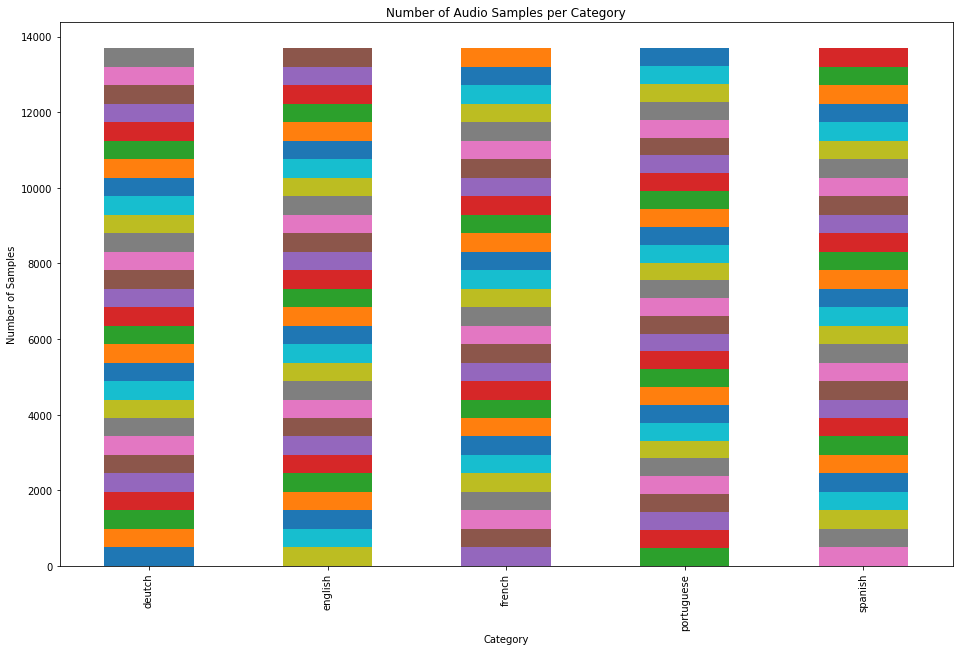

In [25]:
temp = pandas.DataFrame(zip(data['file_path'], data['label'], data['file_name']), 
                        columns=['count', 'label', 'file_name'])
category_group = temp.groupby(['label', 'file_name']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
plot.get_legend().remove()
category_group.head()

## Instâncias por idioma e gênero

count
label      gender       
deutch     f        6845
           m        6846
english    f        6846
           m        6846
french     f        6846
           m        6846
portuguese f        6139
           m        7553
spanish    f        6846
           m        6846

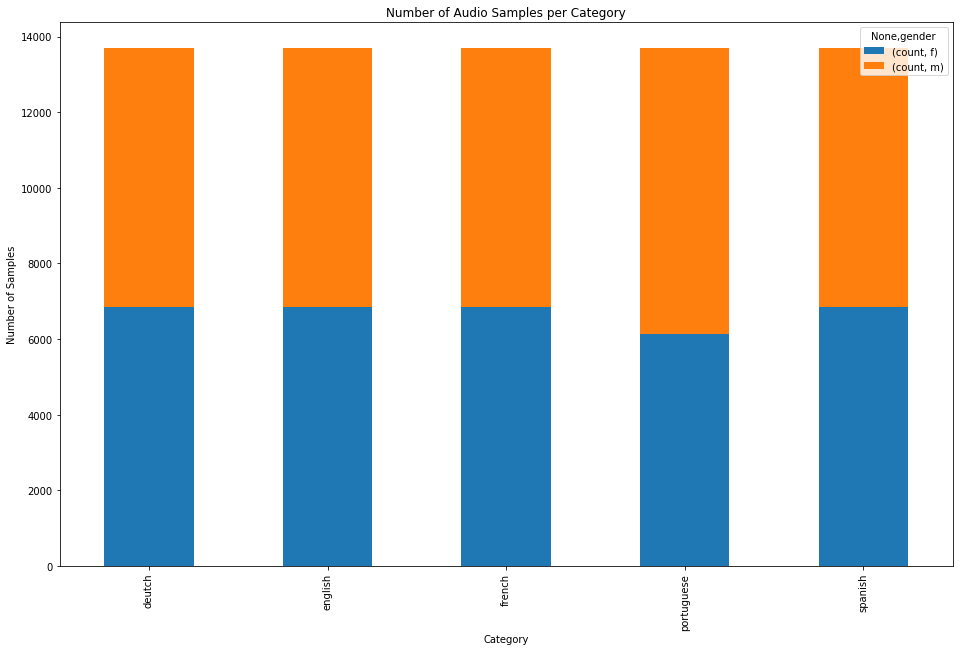

In [26]:
temp = pandas.DataFrame(zip(data['file_path'], data['label'], data['gender']), 
                        columns=['count', 'label', 'gender'])
category_group = temp.groupby(['label', 'gender']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

## Instâncias por _data augmentation_

In [27]:
temp = data['augmented_data'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Data Augmentation')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por idioma e _data augmentation_

count
label      augmented_data       
deutch     True            13691
english    True            13692
french     True            13692
portuguese True            13692
spanish    True            13692

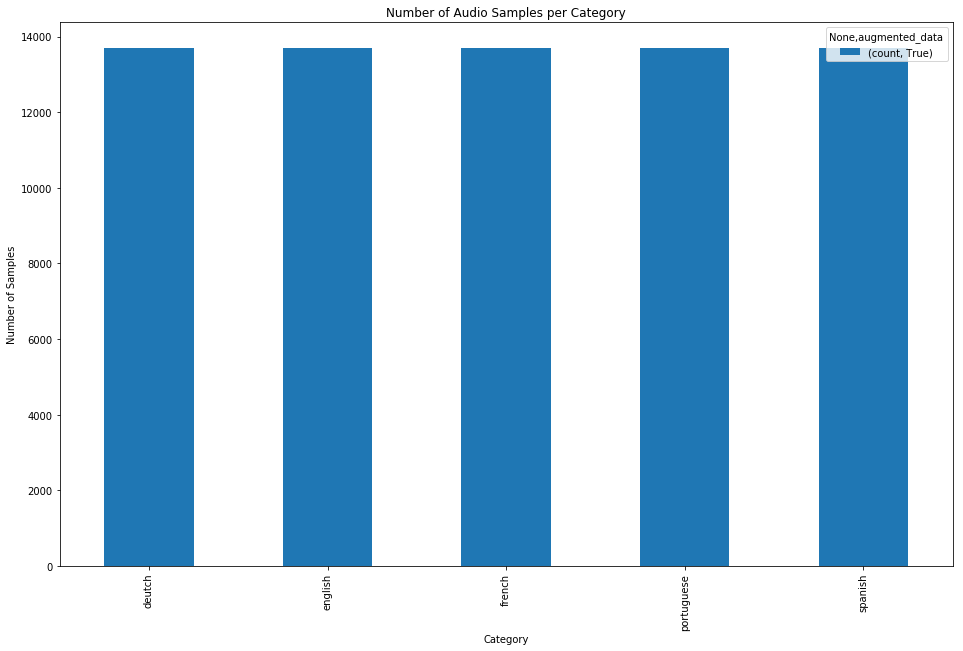

In [28]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['augmented_data']), 
                        columns=['count', 'label', 'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

count  speed_changing  pitch_changing  noise_add  \
label      augmented_data                                                     
deutch     True            13691            5320            5151       2576   
english    True            13692            5320            5152       2576   
french     True            13692            5320            5152       2576   
portuguese True            13692            5321            5153       2573   
spanish    True            13692            5320            5152       2576   

                           low_pass  
label      augmented_data            
deutch     True               13691  
english    True               13692  
french     True               13692  
portuguese True               13692  
spanish    True               13692

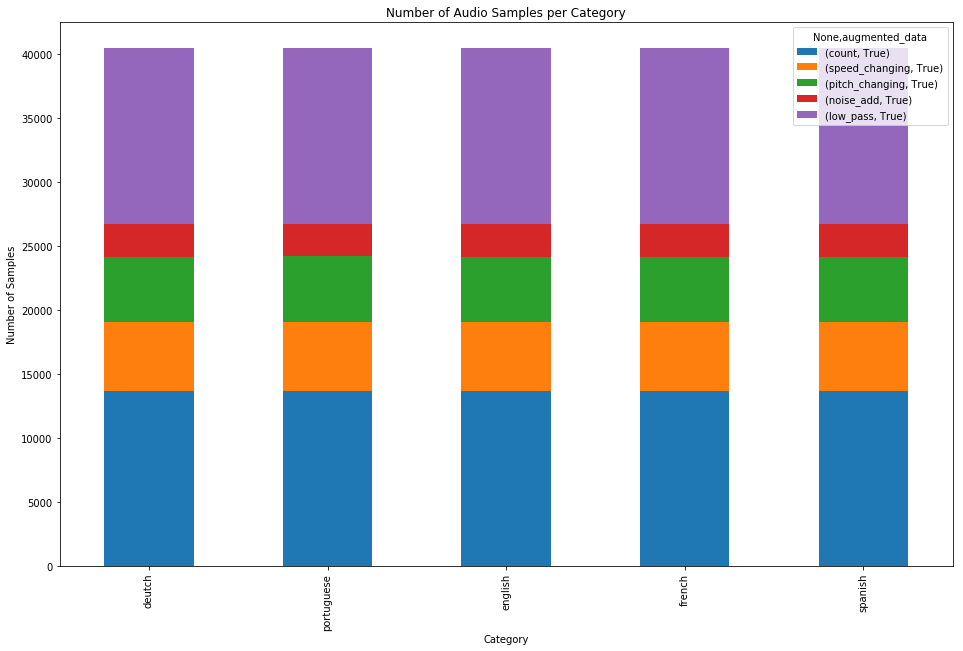

In [29]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['speed_changing'],
                            data['pitch_changing'], data['noise_add'], data['low_pass'], data['augmented_data']), 
                        columns=['count', 'label', 'speed_changing', 'pitch_changing', 'noise_add', 'low_pass',
                                'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
#category_group = category_group[category_group.speed_changing != 0]
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group.head()

## Waveform 

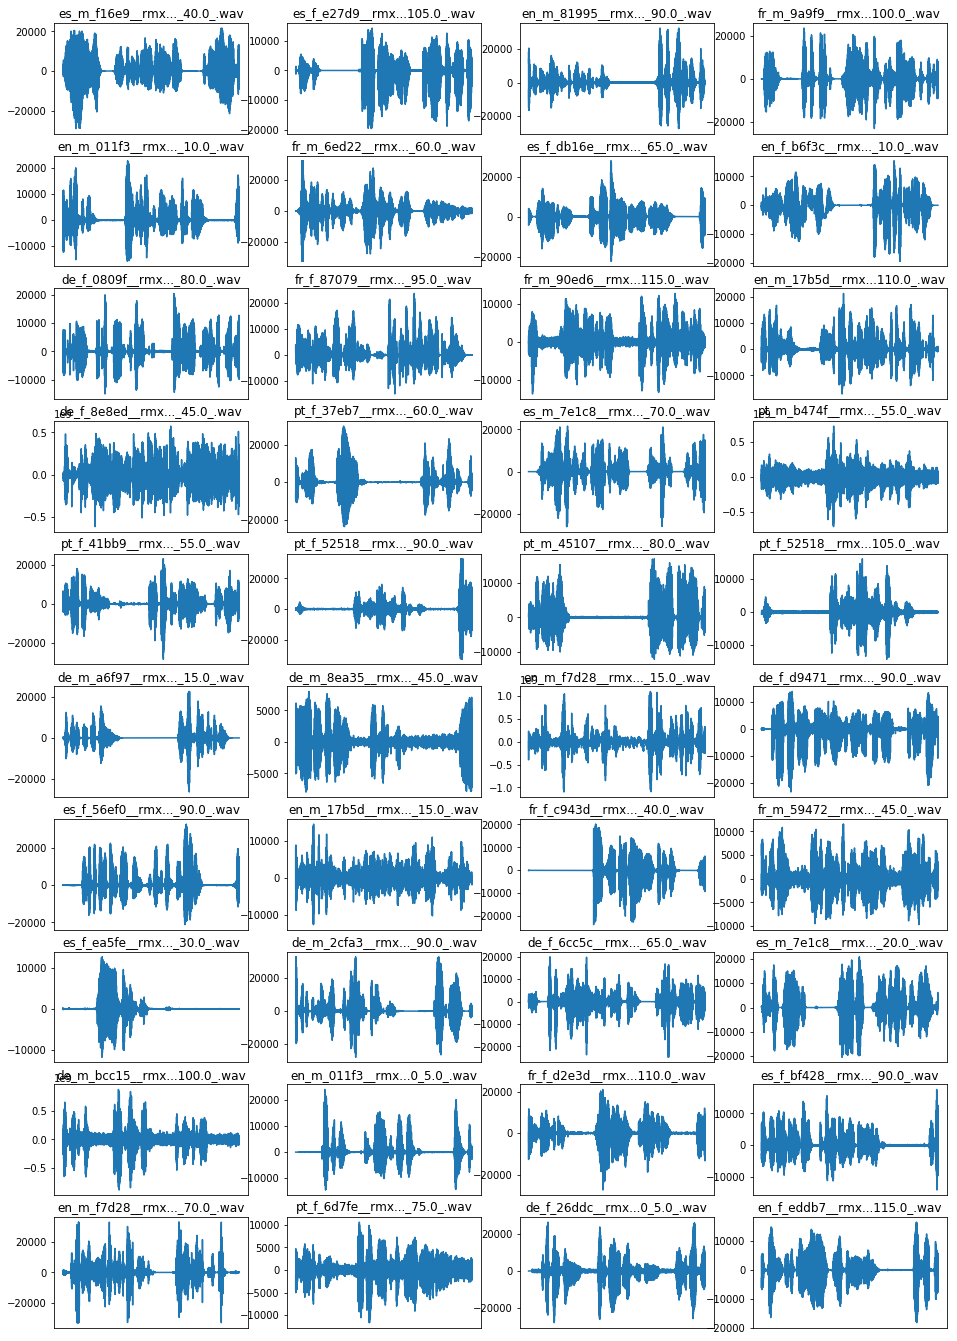

In [30]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    ax[i//4, i%4].plot(samples['time_series'][idx])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioWaveform-{}-{}".format(DATASET, GROUP), dpi=900) 

## Spectrogram

In [31]:
sr, b = wavfile.read(data['file_path'][0])

In [32]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

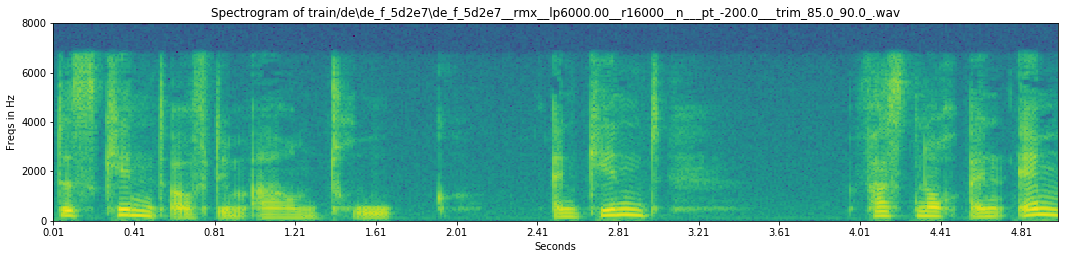

In [33]:
freqs, times, spectrogram = log_specgram(b, sr)

fig = plt.figure(figsize=(18, 8))
ax2 = fig.add_subplot(211)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::40])
ax2.set_xticks(times[::40])
ax2.set_title('Spectrogram of ' + data['file_path'][0])
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [34]:
print("Size of training data", data.shape)

Size of training data (68459, 9)


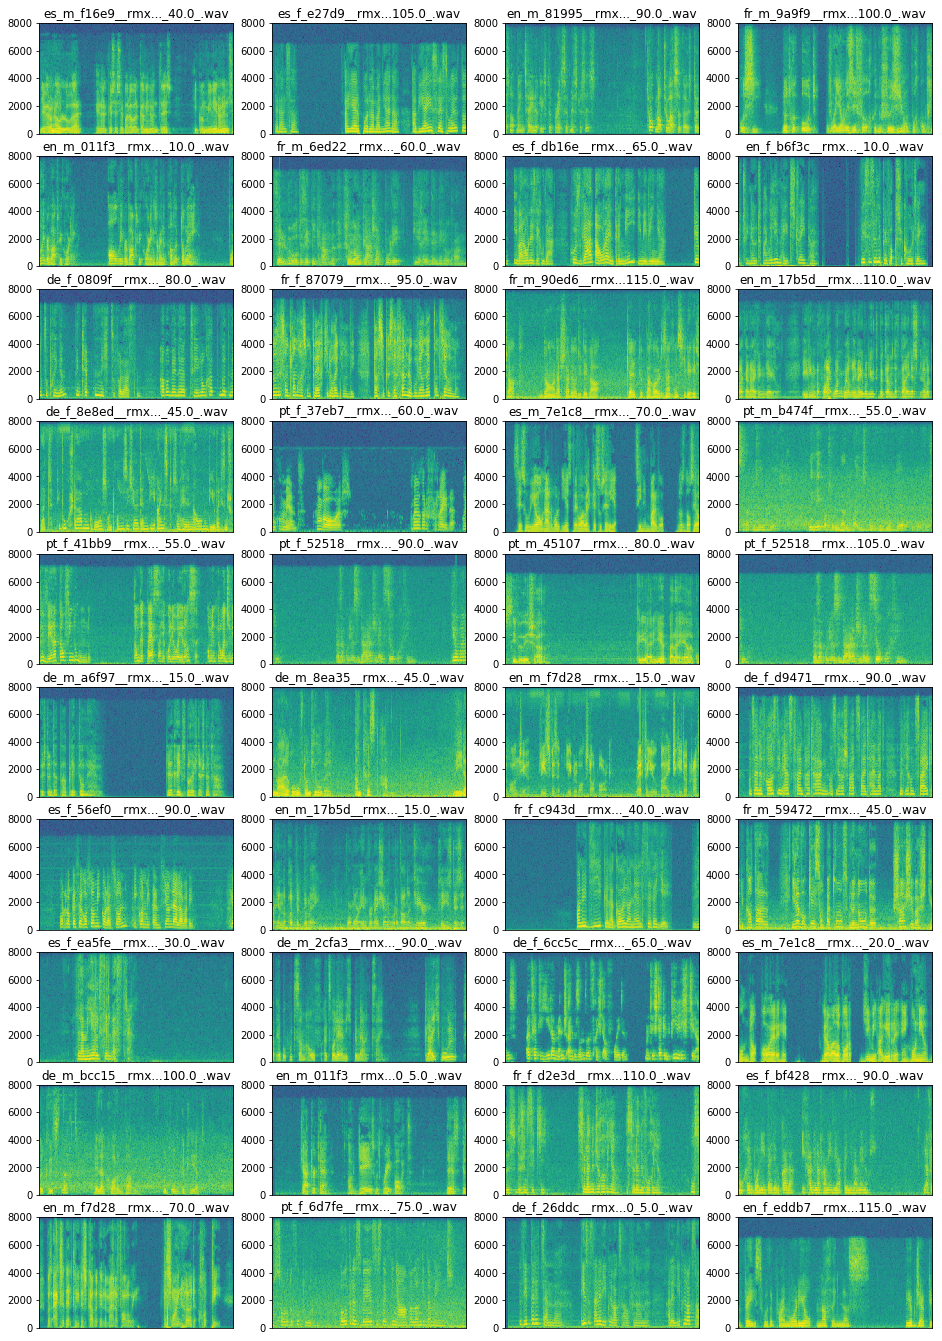

In [35]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = log_specgram(samples['time_series'][idx], sr)
    ax[i//4, i%4].imshow(spectrogram.T, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::40])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioSpectrograms-{}-{}".format(DATASET, GROUP), dpi=900) 

## MFCC

In [36]:
def mfcc_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc

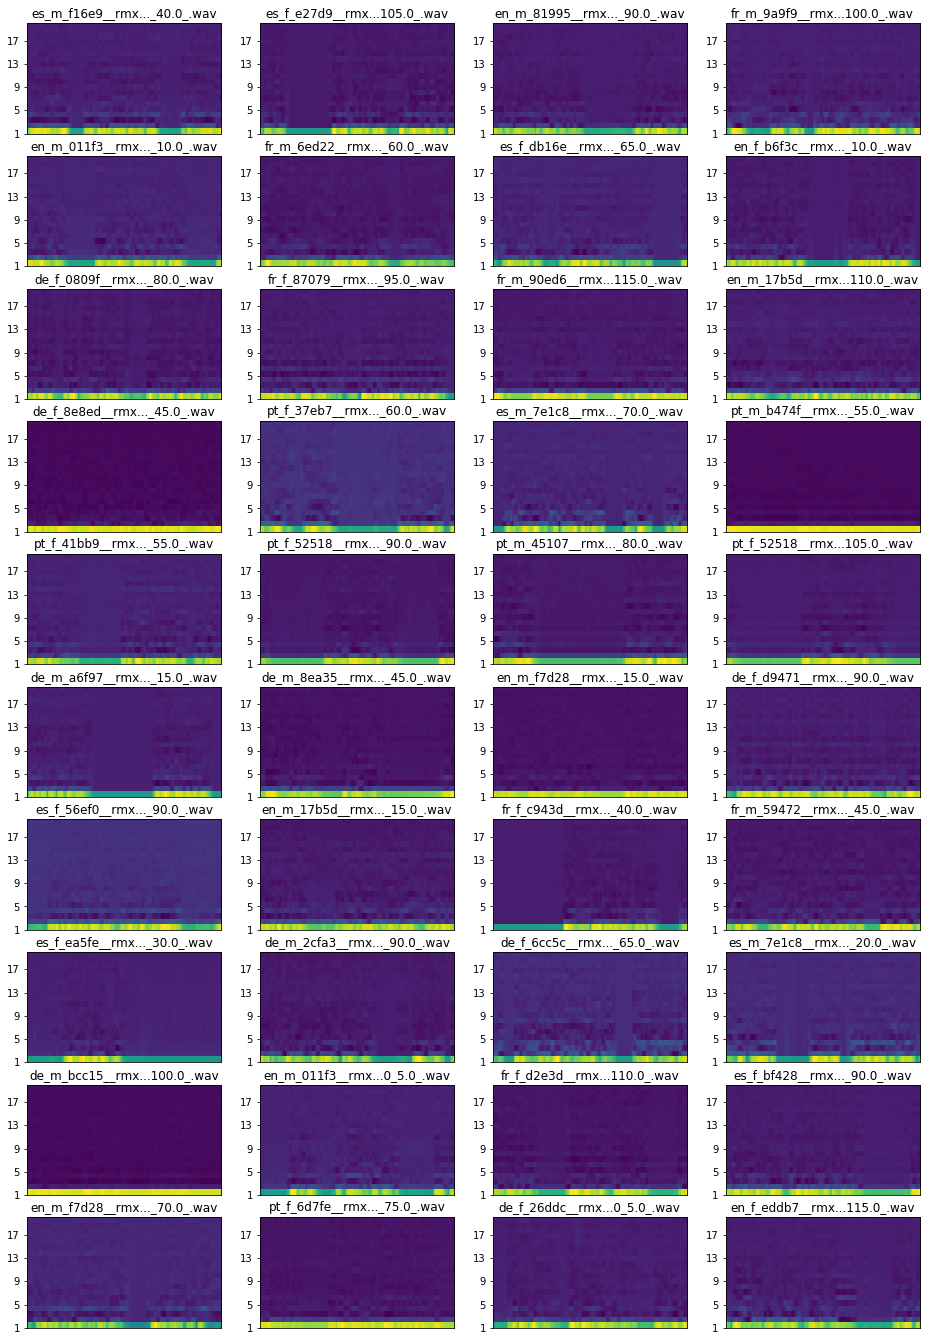

In [37]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_specgram(samples['time_series'][idx], sr,
                                              samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMFCCs-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta

In [38]:
def mfcc_delta_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

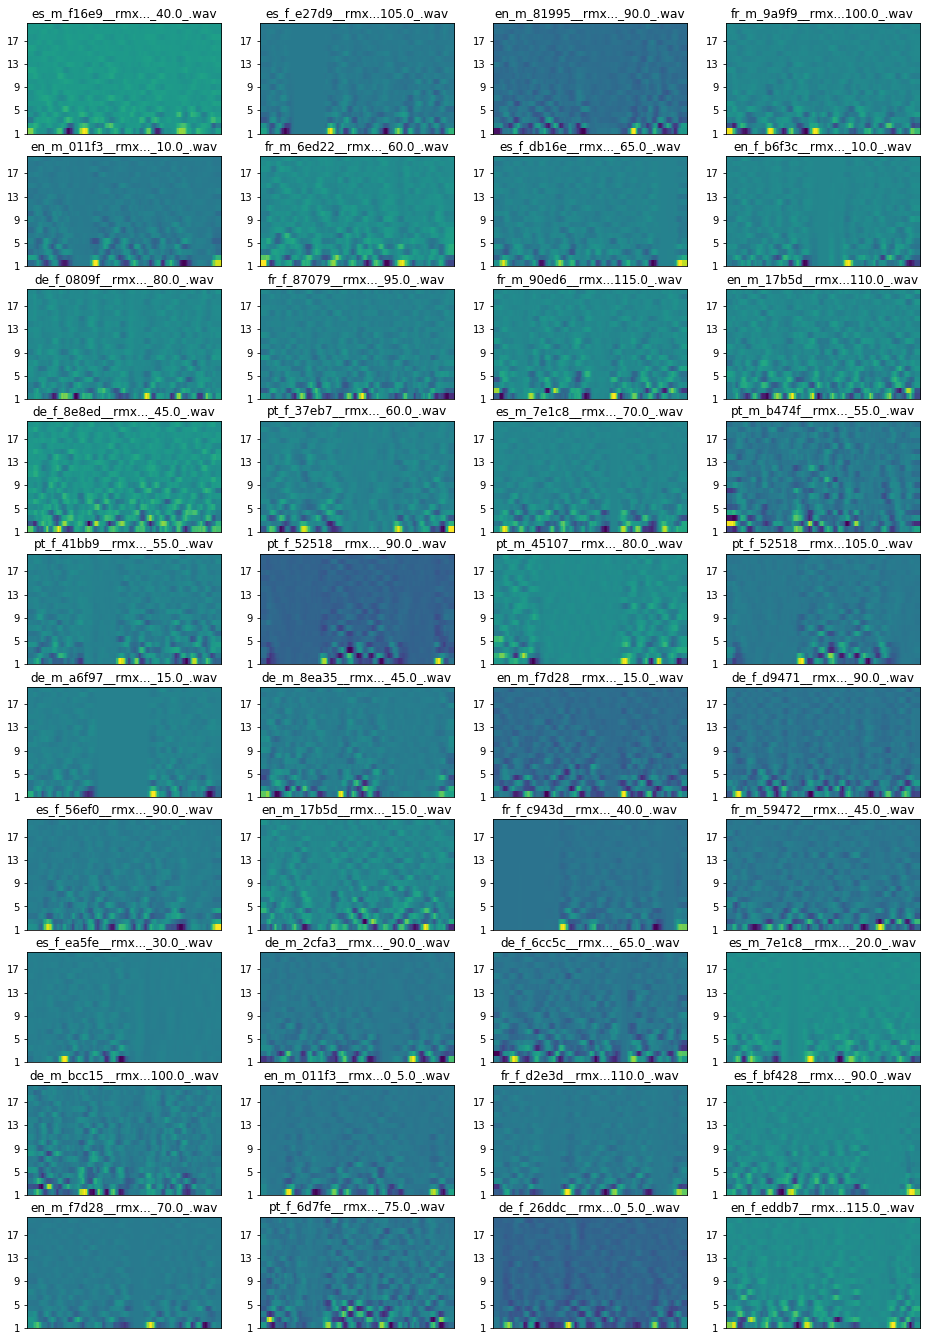

In [39]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_delta_specgram(samples['time_series'][idx], sr,
                                                    samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta Deltas

In [40]:
def mfcc_dd_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc, order=2)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

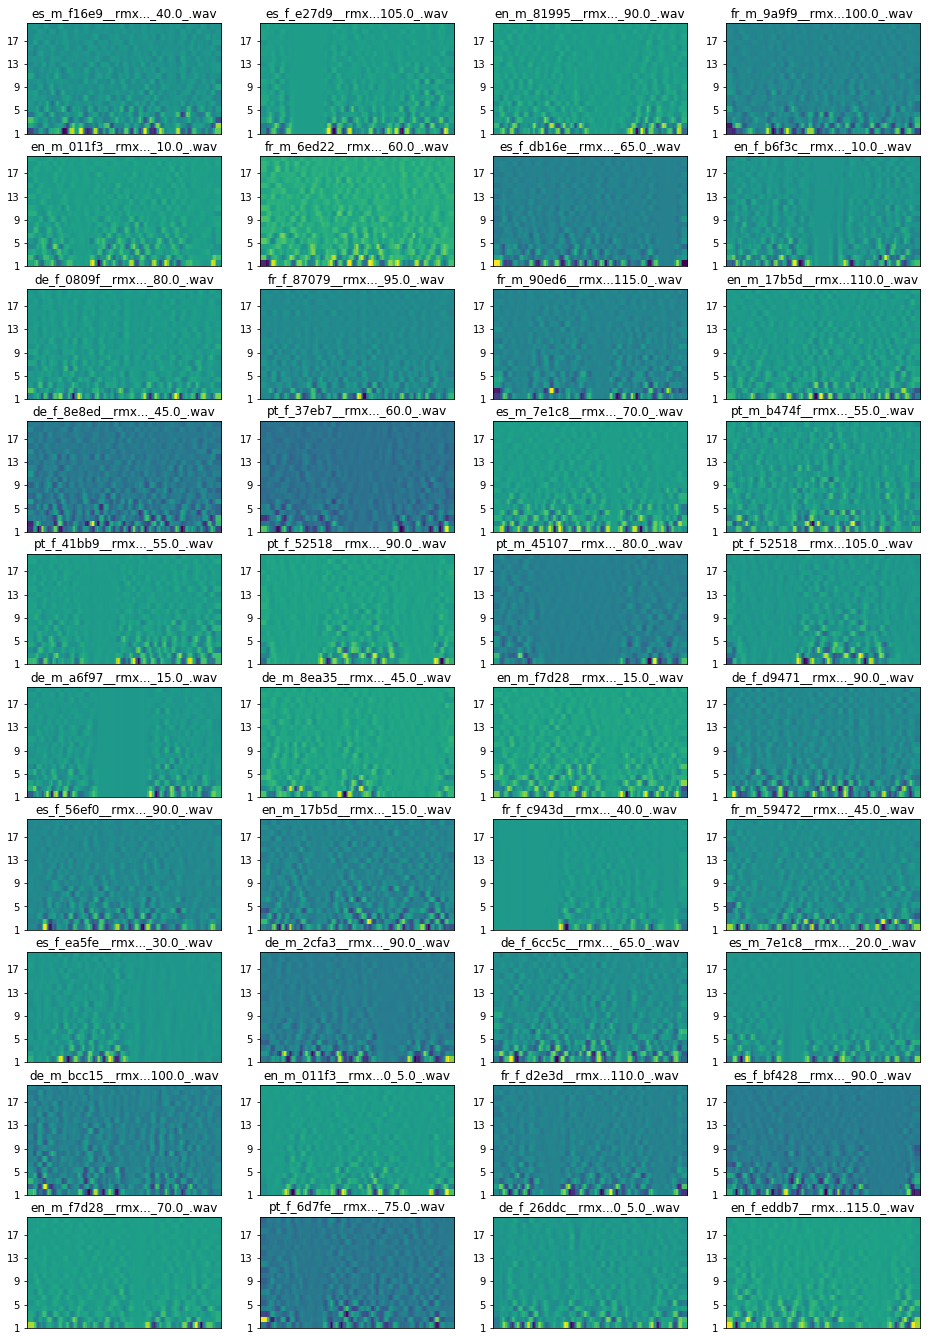

In [41]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_dd_specgram(samples['time_series'][idx], sr,
                                                 samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltaDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

## Mel Spectrogram

In [42]:
def mel_specgram(audio, sample_rate, nframes):
    spec = librosa.feature.melspectrogram(np.asarray(audio, dtype='Float64'), 
                                          sample_rate)
    times = np.linspace(0, nframes/sample_rate, spec.shape[0])
    freqs = np.linspace(1, spec.shape[1], spec.shape[1])
    return freqs, times, spec

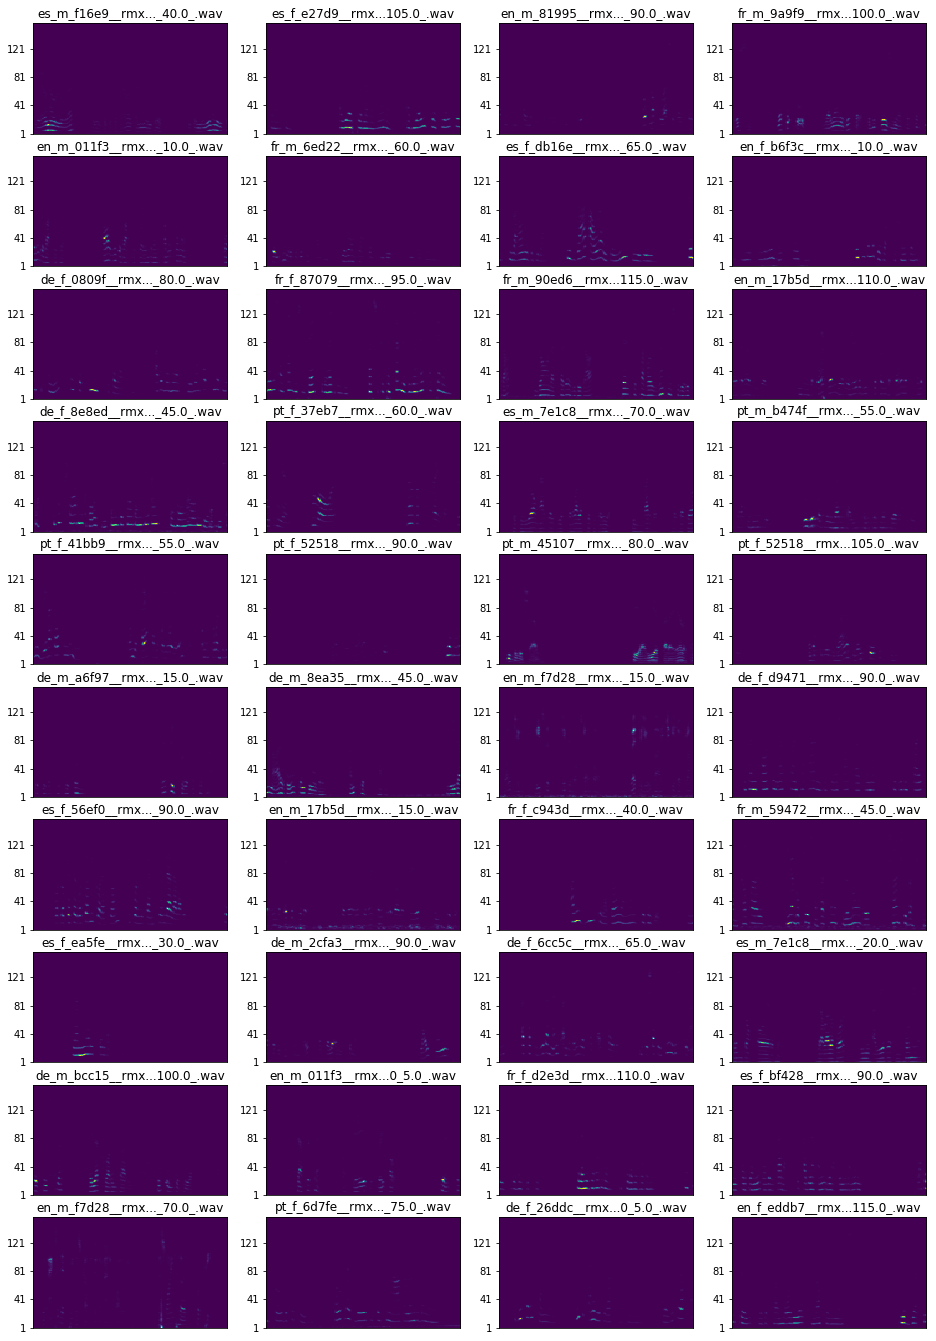

In [43]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mel_specgram(samples['time_series'][idx], sr,
                                             samples['nframes'][idx])
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMelSpecs-{}-{}".format(DATASET, GROUP), dpi=900)  